<a href="https://colab.research.google.com/github/Lohitasrith01/Multi-Agent-Autonomous-Drone-Navigation-Using-Reinforcement-Learning-in-AirSim-/blob/main/maddpg_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.6 MB/s eta 0:00:00


# Multi Agent Environment Definition

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


class MultiAgentEnv(gym.Env):
    def __init__(self, num_agents=2, grid_size=6, obstacle_count=2):
        super(MultiAgentEnv, self).__init__()
        self.num_agents = num_agents
        self.grid_size = grid_size
        self.obstacle_count = obstacle_count
        self.action_space = spaces.MultiDiscrete([4] * num_agents)  # 4 actions for each agent
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(num_agents, 2), dtype=np.int32)

        # Initialize positions for agents, goals, and obstacles
        self.agent_positions = np.zeros((num_agents, 2), dtype=np.int32)
        self.goal_positions = []
        self.obstacle_positions = []

        self.steps_taken = 0
        self.agents_at_goals = [False] * self.num_agents  # Track which agents have reached their goals

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.agent_positions = np.array([[0, 0] for _ in range(self.num_agents)], dtype=np.int32)
        self.obstacle_positions = [self.random_position(avoid=[tuple(pos) for pos in self.agent_positions]) for _ in range(self.obstacle_count)]
        avoid_positions = [tuple(pos) for pos in self.agent_positions] + self.obstacle_positions
        self.goal_positions = [self.random_position(avoid=avoid_positions) for _ in range(self.num_agents)]
        self.steps_taken = 0
        self.agents_at_goals = [False] * self.num_agents  # Reset agent goal statuses

        obs = self.get_state()
        info = {}
        return obs, info

    def step(self, actions):
      self.steps_taken += 1
      rewards = np.zeros(self.num_agents, dtype=np.float32)  # Reward for each agent
      terminated = [False] * self.num_agents
      truncated = self.steps_taken >= 100  # Truncate if max steps reached

      # Calculate initial distances to goals
      initial_distances = np.array(
          [np.linalg.norm(self.agent_positions[i] - self.goal_positions[i], ord=1) for i in range(self.num_agents)]
      )  # Manhattan distance

      new_positions = np.copy(self.agent_positions)
      for i, action in enumerate(actions):
          # Ensure action is a valid scalar
          action = int(action)

          # Check for valid action space
          if action < 0 or action >= 4:
              rewards[i] -= 1  # Penalty for invalid action
              continue

          # Move agents based on the action
          if action == 0:  # Move up
              new_positions[i][1] = max(0, self.agent_positions[i][1] - 1)
          elif action == 1:  # Move down
              new_positions[i][1] = min(self.grid_size - 1, self.agent_positions[i][1] + 1)
          elif action == 2:  # Move left
              new_positions[i][0] = max(0, self.agent_positions[i][0] - 1)
          elif action == 3:  # Move right
              new_positions[i][0] = min(self.grid_size - 1, self.agent_positions[i][0] + 1)

          # Check if agent hits its goal
          if tuple(new_positions[i]) == self.goal_positions[i]:
              rewards[i] += 50  # Goal reward
              terminated[i] = True

          # Handle collisions with other agents
          for j, pos in enumerate(new_positions):
              if i != j and np.array_equal(new_positions[i], pos):
                  rewards[i] -= 20  # Collision penalty
                  rewards[j] -= 20
                  new_positions[i] = self.agent_positions[i]  # Revert position

      # Check for obstacle collisions
      for i, pos in enumerate(new_positions):
          if tuple(pos) in self.obstacle_positions:
              rewards[i] -= 20  # Obstacle penalty
              new_positions[i] = self.agent_positions[i]  # Revert position

      # Calculate new distances to goals and reward for progress
      new_distances = np.array(
          [np.linalg.norm(new_positions[i] - self.goal_positions[i], ord=1) for i in range(self.num_agents)]
      )
      for i in range(self.num_agents):
          if not terminated[i]:  # Only reward progress for agents not already at the goal
              distance_change = initial_distances[i] - new_distances[i]
              if distance_change > 0:  # Agent got closer to the goal
                  rewards[i] += 5 * distance_change  # Scale the reward by the distance reduction

      # Assign negative step rewards to encourage efficient paths
      rewards -= 1

      # Update agent positions
      self.agent_positions = new_positions

      # Check if all agents have reached their goals
      all_terminated = all(terminated)

      obs = self.get_state()
      info = {}  # Add additional information if necessary

      return obs, rewards, all_terminated, truncated, info



    def get_state(self):
        return self.agent_positions

    def render(self, mode='human'):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(1, self.grid_size, 1))
        ax.set_yticks(np.arange(1, self.grid_size, 1))
        ax.grid(True)

        colors = ["yellow", "orange", "purple", "green", "blue"]

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                color = "white"
                text = ""

                if (x, y) in self.obstacle_positions:
                    color = "red"
                    text = "Obstacle"

                elif any(tuple(goal) == (x, y) for goal in self.goal_positions):
                    idx = [tuple(goal) for goal in self.goal_positions].index((x, y))
                    color = colors[idx % len(colors)]
                    text = f"Goal {idx}"

                for i, pos in enumerate(self.agent_positions):
                    if tuple(pos) == (x, y):
                        color = "cyan" if not self.agents_at_goals[i] else "green"
                        text = f"Agent {i}"

                ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))
                ax.text(x + 0.5, y + 0.5, text, ha="center", va="center", fontsize=10)

        plt.title(f"Multi-Agent Environment | Steps: {self.steps_taken}")
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.gca().invert_yaxis()
        plt.show()

    def random_position(self, avoid=None):
        while True:
            position = tuple(np.random.randint(self.grid_size, size=2))
            if avoid is None or position not in avoid:
                return position





# DQN Design and Training

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Define Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Replay Buffer
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, terminated):
        """Store a single transition in the buffer."""
        self.buffer.append((state, action, reward, next_state, terminated))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(terminateds, dtype=np.bool_),
        )

    def __len__(self):
        return len(self.buffer)


# Double DQN Agent
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, tau=0.005):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau

        # Initialize networks
        self.policy_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return np.random.randint(0, self.action_dim)  # Random action
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy_net(state)).item()

    def update(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)

        # Q-values
        current_q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Loss and optimization
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update of target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)

# Training Loop

def train(env, num_episodes=1000, batch_size=64, buffer_capacity=10000, epsilon_decay=0.995, min_epsilon=0.01):
    num_agents = env.num_agents
    state_dim = env.observation_space.shape[1]
    action_dim = env.action_space.nvec[0]

    agents = [DoubleDQNAgent(state_dim, action_dim) for _ in range(num_agents)]
    replay_buffer = ReplayBuffer(buffer_capacity)

    epsilon = 1.0
    episode_rewards = []  # To store total rewards for each episode

    for episode in range(num_episodes):
        states, _ = env.reset()
        total_rewards = np.zeros(num_agents)

        for step in range(100):  # Max steps per episode
            actions = [agent.select_action(states[i], epsilon) for i, agent in enumerate(agents)]
            next_states, rewards, terminated, truncated, _ = env.step(actions)

            # Store transitions in the replay buffer for each agent
            for i in range(num_agents):
                replay_buffer.push(states[i], actions[i], rewards[i], next_states[i], terminated)

                # Accumulate rewards
                total_rewards[i] += rewards[i]

            # Update states
            states = next_states

            # Check for global termination or truncation
            if terminated or truncated:
                break

            # Update agents
            for agent in agents:
                agent.update(replay_buffer, batch_size)

        # Record total rewards for this episode
        episode_rewards.append(np.sum(total_rewards))

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        print(f"Episode {episode + 1}, Total Rewards: {np.sum(total_rewards)}")

    # Plotting the reward per episode
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes + 1), episode_rewards, label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward per Episode")
    plt.legend()
    plt.grid()
    plt.show()

    print("Training complete.")
    return agents



Episode 1, Total Rewards: 65.0
Episode 2, Total Rewards: -140.0
Episode 3, Total Rewards: 140.0
Episode 4, Total Rewards: 0.0
Episode 5, Total Rewards: 45.0
Episode 6, Total Rewards: -295.0
Episode 7, Total Rewards: -145.0
Episode 8, Total Rewards: -190.0
Episode 9, Total Rewards: 0.0
Episode 10, Total Rewards: -105.0
Episode 11, Total Rewards: -420.0
Episode 12, Total Rewards: 322.0
Episode 13, Total Rewards: 10.0
Episode 14, Total Rewards: -150.0
Episode 15, Total Rewards: -290.0
Episode 16, Total Rewards: -570.0
Episode 17, Total Rewards: 155.0
Episode 18, Total Rewards: 68.0
Episode 19, Total Rewards: -320.0
Episode 20, Total Rewards: -295.0
Episode 21, Total Rewards: -300.0
Episode 22, Total Rewards: -220.0
Episode 23, Total Rewards: -230.0
Episode 24, Total Rewards: -240.0
Episode 25, Total Rewards: 224.0
Episode 26, Total Rewards: 510.0
Episode 27, Total Rewards: -70.0
Episode 28, Total Rewards: -5.0
Episode 29, Total Rewards: 70.0
Episode 30, Total Rewards: -565.0
Episode 31, T

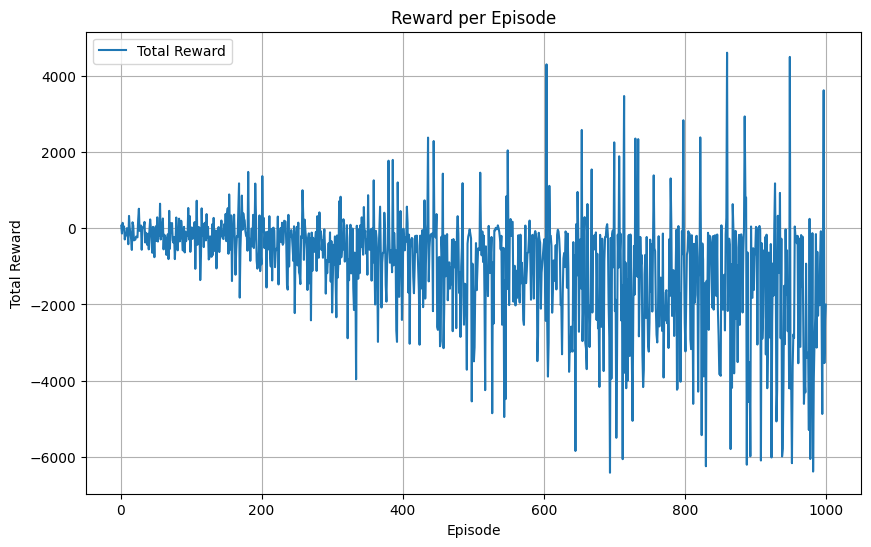

Training complete.


In [ ]:
env = MultiAgentEnv()
train(env)

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.2 MB/s eta 0:00:00


# Hyper Parameter Training using Optuna on the DQN

[I 2024-12-05 02:00:14,536] A new study created in memory with name: no-name-d2155d19-7fbc-448b-844e-d41223c221b8
<ipython-input-23-ff9b36ba8d79>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-23-ff9b36ba8d79>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
<ipython-input-23-ff9b36ba8d79>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_decay = trial.suggest_uniform("epsilon_decay", 0.9, 0.999)
[I 2024

Best Hyperparameters: {'learning_rate': 4.795330512411649e-05, 'gamma': 0.9243733565608311, 'epsilon_decay': 0.9986821890666847}


<ipython-input-23-ff9b36ba8d79>:67: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

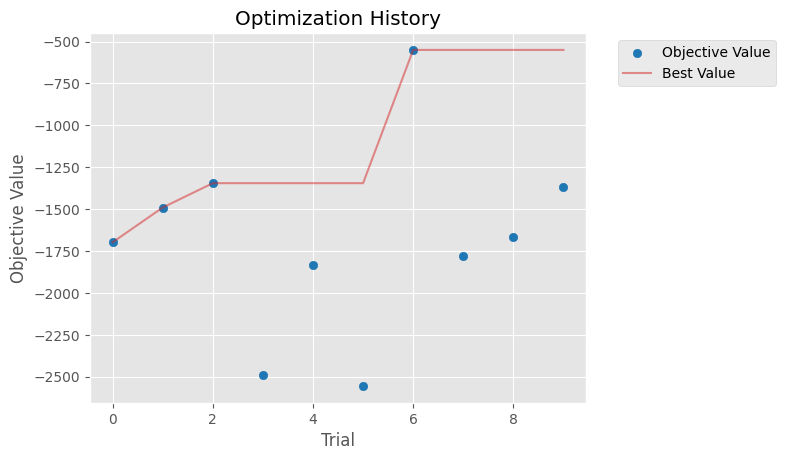

In [ ]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from optuna import Trial

def optimize_hyperparameters(env, num_trials=50, num_episodes=500, batch_size=64, buffer_capacity=10000):
    def objective(trial: Trial):
        # Suggest hyperparameters
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
        gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
        epsilon_decay = trial.suggest_uniform("epsilon_decay", 0.9, 0.999)

        # Set up agents and replay buffer
        num_agents = env.num_agents
        state_dim = env.observation_space.shape[1]
        action_dim = env.action_space.nvec[0]

        agents = [DoubleDQNAgent(state_dim, action_dim, lr=learning_rate, gamma=gamma) for _ in range(num_agents)]
        replay_buffer = ReplayBuffer(buffer_capacity)

        epsilon = 1.0
        total_rewards = []

        # Training loop
        for episode in range(num_episodes):
            states, _ = env.reset()
            episode_reward = 0

            for step in range(100):
                actions = [agent.select_action(states[i], epsilon) for i, agent in enumerate(agents)]
                next_states, rewards, terminated, truncated, _ = env.step(actions)

                # Store transitions in replay buffer
                for i in range(num_agents):
                    replay_buffer.push(states[i], actions[i], rewards[i], next_states[i], terminated)
                    episode_reward += rewards[i]

                # Update states
                states = next_states

                # Check for termination
                if terminated or truncated:
                    break

                # Update agents
                for agent in agents:
                    agent.update(replay_buffer, batch_size)

            # Decay epsilon
            epsilon = max(0.01, epsilon * epsilon_decay)

            # Record total reward
            total_rewards.append(episode_reward)

        # Objective value: average reward over the last 100 episodes
        return np.mean(total_rewards[-100:])

    # Run optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=num_trials)

    # Best hyperparameters
    print("Best Hyperparameters:", study.best_params)

    # Plot optimization results
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    return study

# Example usage
env = MultiAgentEnv()
study = optimize_hyperparameters(env, num_trials=10, num_episodes=500)
